In [11]:
import pandas as pd
from sqlalchemy import create_engine
from password import password
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [4]:
protocol = 'postgresql'
username = 'postgres'
password = password
host = 'localhost'
port = 5432
database_name = 'churn_pred'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)
connection = engine.connect()

In [6]:
df = pd.read_sql("SELECT * FROM fact_churn", connection)
df.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,state_WI,state_WV,state_WY,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,0,0,0,0,1,0,1,0,0,1
1,118,0,223.4,98,37.98,220.6,101,18.75,203.9,118,...,0,0,0,0,0,1,0,1,1,0
2,62,0,120.7,70,20.52,307.2,76,26.11,203.0,99,...,0,0,0,0,1,0,1,0,1,0
3,93,0,190.7,114,32.42,218.2,111,18.55,129.6,121,...,0,0,0,0,0,1,1,0,1,0
4,174,0,124.3,76,21.13,277.1,112,23.55,250.7,115,...,0,0,0,0,1,0,1,0,1,0


In [7]:
# Split the data into X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(['churn'], axis=1)
y = df['churn'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.33)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X.sample(5)

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,state_WI,state_WV,state_WY,area_code_area_code_408,area_code_area_code_415,area_code_area_code_510,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes
2550,111,0,249.8,109,42.47,242.4,106,20.60,231.8,78,...,0,0,0,1,0,0,1,0,1,0
49,71,0,197.9,108,33.64,181.5,109,15.43,281.4,56,...,0,0,0,0,1,0,1,0,1,0
2768,157,0,180.4,123,30.67,194.0,98,16.49,227.3,88,...,0,0,1,0,1,0,0,1,1,0
4710,111,0,184.2,92,31.31,215.0,96,18.28,100.1,64,...,0,0,0,0,0,1,1,0,1,0
2202,99,0,128.8,86,21.90,203.9,105,17.33,282.6,131,...,0,0,0,1,0,0,1,0,1,0


In [8]:
# Train a Logistic Regression model print the model score
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(max_iter=10000)
log.fit(X_train_scaled, y_train)

print(f"Training Data Score: {log.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {log.score(X_test_scaled, y_test)}")

Training Data Score: 0.8397014925373134
Testing Data Score: 0.8090909090909091


k: 1, Train/Test Score: 1.000/0.754
k: 3, Train/Test Score: 0.871/0.796
k: 5, Train/Test Score: 0.847/0.805
k: 7, Train/Test Score: 0.835/0.813
k: 9, Train/Test Score: 0.833/0.813
k: 11, Train/Test Score: 0.832/0.811
k: 13, Train/Test Score: 0.830/0.813
k: 15, Train/Test Score: 0.829/0.813
k: 17, Train/Test Score: 0.829/0.813
k: 19, Train/Test Score: 0.828/0.813


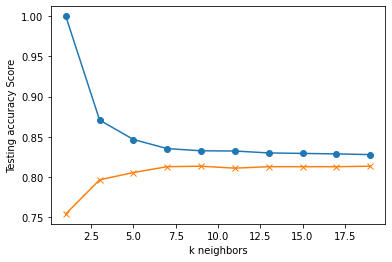

In [12]:
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()